## Basical settings

Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
%matplotlib inline
from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import os, json, random, cv2
from PIL import Image
from numpyencoder import NumpyEncoder
import multiprocessing
import time
import torch

/home/yl127/anaconda3/envs/astrodet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi
print(torch.__version__)
print(torch.cuda.is_available())

Fri Feb 10 14:37:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000035:04:00.0 Off |                  Off |
| N/A   36C    P0    37W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Global variables

In [3]:
wavelengths     = np.arange(400, 800)*u.nm
FWHM            = 0.5
lambda_Na       = 589.0*u.nm
lambda_Mg       = 518.3*u.nm
width           = 1000
height          = 1500

dir='./dataset/'

## Generate dataset

Define the function to generate the image. 

In [3]:
def add_background(image_3d):
    '''
    '''
    # TODO: mutate the background
    for i in range(400):
        image_3d[:,:,i] += int(30-0.06*i)
    return image_3d

def add_stars(image_3d, coord_stars, amp_stars, T_stars): 
    '''
    '''
    # psf
    PSF = functional_models.Gaussian2D(x_stddev=FWHM, y_stddev=FWHM)
    # draw N stars with radius FWHM/2
    for [x, y], amp_star, T_star in zip(coord_stars, amp_stars, T_stars): 
        # spectrum
        BB = models.BlackBody(temperature=T_star)
        # add star to the image
        radius = int(5*FWHM)
        xx = np.arange(-radius, radius+1)
        yy = np.arange(-radius, radius+1)
        XX, YY = np.meshgrid(xx, yy)
        star = np.repeat(PSF(XX, YY)[:,:,np.newaxis], 400, axis=2)*BB(wavelengths).value*amp_star
        star = star.astype('uint16')
        image_3d[x-radius:x+radius+1,y-radius:y+radius+1,:] += star
    return image_3d

def add_meteor(image_3d, coord_meteor, amp_meteor, T_meteor, dir_meteor, length_meteor): 
    '''
    '''
    # spectrum - continuous spectrum
    BB = models.BlackBody(temperature=T_meteor)
    meteor_x = BB(wavelengths).value*amp_meteor
    # spectrum - emission line
    amp_Na = amp_meteor*2e-6
    amp_Mg = amp_meteor*1e-6
    emission_Na = functional_models.Gaussian1D(mean=lambda_Na.value, stddev=FWHM)
    emission_Mg = functional_models.Gaussian1D(mean=lambda_Mg.value, stddev=FWHM)
    meteor_x += emission_Na(wavelengths.value)*amp_Na
    meteor_x += emission_Mg(wavelengths.value)*amp_Mg
    # trajectory
    meteor_y = np.arange(length_meteor)
    amplitude = 1e3
    # TODO: use true trajectory
    meteor_y = (meteor_y*10/length_meteor)**(0.1) - meteor_y/length_meteor
    meteor_y = meteor_y*amplitude
    meteor = np.outer(meteor_y, meteor_x)
    # draw meteor
    dx = np.cos(dir_meteor)
    dy = np.sin(dir_meteor)
    PSF = functional_models.Gaussian2D(x_stddev=FWHM, y_stddev=FWHM)
    for i in range(length_meteor): 
        radius = int(5*FWHM)
        x_plot = int(coord_meteor[0] + dx*i)
        y_plot = int(coord_meteor[1] + dy*i)
        xx = np.arange(-radius, radius+1)
        yy = np.arange(-radius, radius+1)
        XX, YY = np.meshgrid(xx, yy)
        star = np.repeat(PSF(XX, YY)[:,:,np.newaxis], 400, axis=2)*meteor[i, :]
        star = star.astype('uint16')
        image_3d[x_plot-radius:x_plot+radius+1,y_plot-radius:y_plot+radius+1,:] += star
    # plt.imshow(meteor)
    # plt.colorbar()
    # plt.show()


    # TODO: return the bounding box
    return image_3d

def add_landscape(image_3d): 
    '''
    TODO
    '''
    return image_3d

def capture(image_3d, direction, length): 
    '''
    '''
    dx = np.cos(direction)
    dy = np.sin(direction)
    for i in range(400): 
        # print(i, int(dx*length*i/400))
        image_3d[:,:,i] = np.roll(image_3d[:,:,i], axis=0, shift=int(dx*length*i/400))
        image_3d[:,:,i] = np.roll(image_3d[:,:,i], axis=1, shift=int(dy*length*i/400))
    image_rgb = np.zeros([width, height, 3], dtype=np.uint16)
    # RGB filter
    # TODO: adjust the RGB curve of camera
    # TODO: adjust the true slit distortion
    gaussian_r = functional_models.Gaussian1D(mean=600, stddev=30)
    gaussian_g = functional_models.Gaussian1D(mean=540, stddev=30)
    gaussian_b = functional_models.Gaussian1D(mean=480, stddev=30)
    filter_r = gaussian_r(wavelengths.value)
    filter_g = gaussian_g(wavelengths.value)
    filter_b = gaussian_b(wavelengths.value)
    filter_r[200:400] = 1-np.arange(200)**2/200**2
    # generate RGB components
    image_rgb[:, :, 0] = np.average(image_3d*filter_r, axis=2)
    image_rgb[:, :, 1] = np.average(image_3d*filter_g, axis=2)
    image_rgb[:, :, 2] = np.average(image_3d*filter_b, axis=2)
    image_rgb = image_rgb.astype('uint16')
    return image_rgb

def augmentation(image_rgb): 
    '''
    Add the lens effect such as disortion and gaussian noise
    TODO: use `imgaug`
    '''
    return image_rgb


def generate_image(coord_stars, amp_stars, T_stars, coord_meteor, amp_meteor, T_meteor, 
                    angle_meteor, length_meteor, angle_slit, length_slit): 
    '''
    function to generate the image. 
    Args: 
        The position of all the stars, the meteor, etc.: 
        coords_stars    [N, 2]      the coordinates of stars plotted in the diagram. Will also give the number of stars
        TODO...
        angle_slit      [0, 2pi)
        angle_meteor    [0, 2pi)
        length_meteor   int         how long the meteor is 
        length_slit     int         how long the track of spectrum is
    Return: 
        one RGB image
    '''
    image_3d = np.zeros([width, height, 400], dtype=np.uint16)           # 0-65536, valid in 0-256 TODO: change to float16? 
    image_3d = add_background(image_3d)
    image_3d = add_stars(image_3d, coord_stars, amp_stars, T_stars)
    image_3d = add_meteor(image_3d, coord_meteor, amp_meteor, T_meteor, angle_meteor, length_meteor)
    image_rgb = capture(image_3d, angle_slit, length_slit)
    image_rgb = augmentation(image_rgb)
    # clip the image
    image_rgb = np.clip(image_rgb, 0, 255)# including 0 and 255
    # image_rgb = image_rgb.astype('uint8')
    return image_rgb #image_3d[:,:,0]
    



In [9]:
def generate_dataset(num_images, dir='./dataset/'): 
    '''
    generate the image and save the images in the directory. 
    Args: 
        num_images  
        dir
    Output: 
        JPG files and a json file in COCO format in the directory
    No return
    NOTE: returns an image for testing
    '''
    # TODO: check if the directory is usable
    # customized variables applying to all images
    # TODO: if exception
    labels = json.load(open(os.path.join(dir, 'labels.json'), 'r'))
    anno_id_start = max([i['id'] for i in labels['annotations']]) + 1
    anno_id = anno_id_start
    image_id_start = max([i['id'] for i in labels['images']]) + 1
    # Loop to generate images
    for image_id in range(image_id_start, image_id_start + num_images): 
        filename = str(image_id) + "_" + time.strftime("%Y%m%d-%H%M%S") + ".jpg"
        print('generating image: %s...'%filename)
        # parameters
        num_stars       = 200
        x_stars         = (np.random.rand(num_stars)*(width-10*FWHM)+5*FWHM).astype(np.int16)
        y_stars         = (np.random.rand(num_stars)*(height-10*FWHM)+5*FWHM).astype(np.int16)
        # TODO: change the border where the meteor can show
        length_meteor   = int(np.random.rand()*500)                      # pixel
        x_meteor        = int(np.random.rand()*(width-2*length_meteor)+length_meteor)
        y_meteor        = int(np.random.rand()*(height-2*length_meteor)+length_meteor)
        # image - parameters needed for `generate_image` function
        coord_stars     = np.array([x_stars, y_stars]).T            # [N, 2]pixel
        amp_stars       = np.random.rand(num_stars)*1e8             # [N]erg -> pixel value
        T_stars         = (np.random.rand(num_stars)*15000+5000)*u.K# [N]5000K-20000K
        coord_meteor    = [x_meteor, y_meteor]
        amp_meteor      = np.random.rand()*1e8
        T_meteor        = 2000*u.K
        angle_meteor    = np.random.rand()*2*np.pi                  # radian
        # length_meteor   = int(np.random.rand()*500)                 # pixel
        angle_slit      = np.random.rand()*2*np.pi                  # radian
        length_slit     = 100
        # image
        image = generate_image(coord_stars, amp_stars, T_stars, coord_meteor, amp_meteor, T_meteor, 
                                angle_meteor, length_meteor, angle_slit, length_slit)
        image8 = image.astype(np.uint8)-1
        im = Image.fromarray(image8)
        im.save(os.path.join(dir, filename), quality=100)
        # label - image
        label_image = {
            'license': 1,
            'file_name': filename,
            'height': width,
            'width': height,
            'id': image_id
        }
        labels['images'].append(label_image)
        # label - annotation - meteor
        bbox_x1      = int(min(
            x_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit, 
            x_meteor + np.cos(angle_meteor)*length_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit + np.cos(angle_meteor)*length_meteor, 
        ))
        bbox_y1      = int(min(
            y_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit, 
            y_meteor + np.sin(angle_meteor)*length_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit + np.sin(angle_meteor)*length_meteor, 
        ))
        bbox_x2      = int(max(
            x_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit, 
            x_meteor + np.cos(angle_meteor)*length_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit + np.cos(angle_meteor)*length_meteor, 
        ))
        bbox_y2      = int(max(
            y_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit, 
            y_meteor + np.sin(angle_meteor)*length_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit + np.sin(angle_meteor)*length_meteor, 
        ))
        bbox_w      = bbox_x2 - bbox_x1
        bbox_h      = bbox_y2 - bbox_y1
        start_Na_x  = int(x_meteor + np.cos(angle_slit)*length_slit*(lambda_Na.value-400)/400)
        start_Na_y  = int(y_meteor + np.sin(angle_slit)*length_slit*(lambda_Na.value-400)/400)
        end_Na_x    = int(start_Na_x + np.cos(angle_meteor)*length_meteor)
        end_Na_y    = int(start_Na_y + np.sin(angle_meteor)*length_meteor)
        start_Mg_x  = int(x_meteor + np.cos(angle_slit)*length_slit*(lambda_Mg.value-400)/400)
        start_Mg_y  = int(y_meteor + np.sin(angle_slit)*length_slit*(lambda_Mg.value-400)/400)
        end_Mg_x    = int(start_Mg_x + np.cos(angle_meteor)*length_meteor)
        end_Mg_y    = int(start_Mg_y + np.sin(angle_meteor)*length_meteor)
        label_meteor = {
            'id': anno_id, 
            'image_id': image_id,
            'category_id': 1,
            'bbox': [
                bbox_y1, bbox_x1, bbox_h, bbox_w
            ],
            'keypoints': [
                start_Na_y, start_Na_x, 2, end_Na_y, end_Na_x, 2, 
                start_Mg_y, start_Mg_x, 2, end_Mg_y, end_Mg_x, 2
            ], 
            'num_keypoints': 4
        }
        labels['annotations'].append(label_meteor)
        anno_id += 1
        # label - annotation - stars
        for x, y in coord_stars: 
            start_star_x    = x
            start_star_y    = y
            end_star_x      = int(x + np.cos(angle_slit)*length_slit)
            end_star_y      = int(y + np.sin(angle_slit)*length_slit)
            bbox_x1 = min(start_star_x, end_star_x)
            bbox_y1 = min(start_star_y, end_star_y)
            bbox_x2 = max(start_star_x, end_star_x)
            bbox_y2 = max(start_star_y, end_star_y)
            bbox_w      = bbox_x2 - bbox_x1
            bbox_h      = bbox_y2 - bbox_y1
            # check if the star is valid for labelling
            if 0<=end_star_x and end_star_x<width and 0<=end_star_y and end_star_y<height: 
                label_star = {
                    'id': anno_id, 
                    'image_id': image_id,
                    'category_id': 2,
                    'bbox': [
                        bbox_y1, bbox_x1, bbox_h, bbox_w
                    ],
                    'keypoints': [
                        start_star_y, start_star_x, 2, end_star_y, end_star_x, 2, 0, 0, 0, 0, 0, 0
                    ], 
                    'num_keypoints': 2
                }
                labels['annotations'].append(label_star)
                anno_id += 1
        # rewrite json file everytime finishing generating an image
        with open(os.path.join(dir, 'labels.json'), 'w') as f:
            json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)
    
    return image, labels


Generate the dataset. 

In [ ]:
labels = {
    'info': {
        'description': 'Meteor spectrum fake data',
        'url': 'https://cheysen.fit',
        'version': '0.1',
        'year': 2023,
        'contributor': 'Yichen Liu',
        'date_created': '2023/02/08'
    },
    'licenses': {
        'url': 'NaN',
        'id': 1,
        'name': 'NaN'
    },
    'images': [],
    'annotations': [],
    'categories': [{
            'id': 1,
            'name': 'meteor',
            'keypoints': [
                'start_Na',
                'end_Na',
                'start_Mg',
                'end_Mg',
            ],
            'skeleton': [
                [1, 2],
                [3, 4],
            ]
        },{
            'id': 2,
            'name': 'star',
            'keypoints': [
                'start_star',
                'end_star',
                'start_', 
                'end_'
            ],
            'skeleton': [
                [1, 2],
            ]
        }
    ]
}
with open(os.path.join(dir, 'labels.json'), 'w') as f:
    json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)

num_images = 400
image, labels = generate_dataset(num_images, dir)

plt.figure(figsize=[15, 10])
plt.imshow(image)

generating image 1...
generating image 2...
generating image 3...
generating image 4...
generating image 5...
generating image 6...
generating image 7...
generating image 8...
generating image 9...
generating image 10...
generating image 11...
generating image 13...
generating image 14...
generating image 15...
generating image 16...
generating image 17...
generating image 18...
generating image 19...
generating image 20...
generating image 21...
generating image 22...
generating image 23...
generating image 24...
generating image 25...
generating image 26...
generating image 27...
generating image 28...
generating image 29...
generating image 30...
generating image 31...
generating image 32...
generating image 33...
generating image 34...
generating image 35...
generating image 36...
generating image 37...
generating image 38...
generating image 39...
generating image 40...
generating image 41...
generating image 42...
generating image 43...
generating image 44...
generating image 45.

## Register data

Try to read the dataset we have just generated and confirm that the data is correctly loaded and labelled 

In [1]:
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import os, json, random, cv2
from PIL import Image
from numpyencoder import NumpyEncoder

dir='./dataset/'

register_coco_instances('fake_meteors', {}, os.path.join(dir, 'labels.json'), dir)

/home/yl127/anaconda3/envs/astrodet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(1000, 1500, 3)


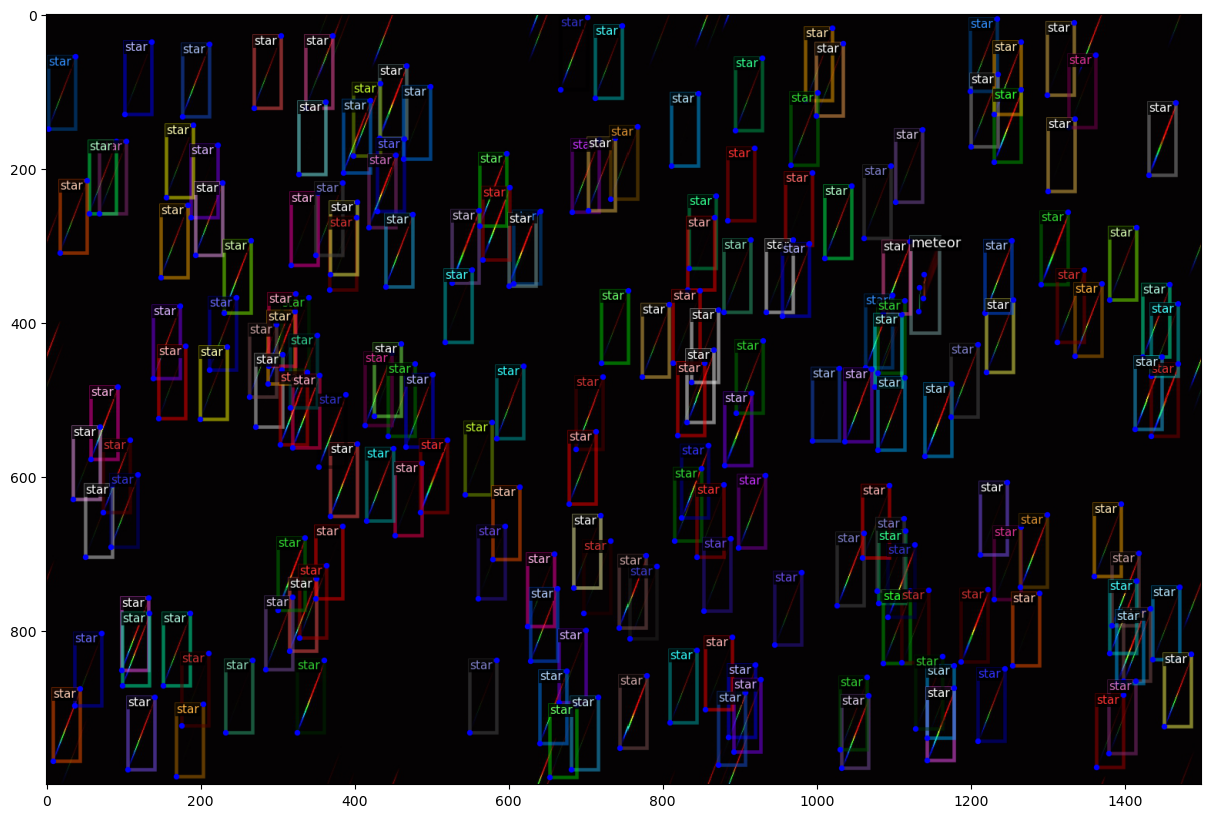

In [2]:

dataset_dicts = DatasetCatalog.get('fake_meteors')
metadata = MetadataCatalog.get('fake_meteors')

for d in random.sample(dataset_dicts, 1):
    img = plt.imread(d["file_name"])
    print(img.shape)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=[15, 10])
    plt.imshow(out.get_image()[:, :, ::-1])


## Train

Using `R50-FPN 3x` model in `COCO Person Keypoint Detection Baselines with Keypoint R-CNN` 

In [30]:
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.config import get_cfg

out_dir = './output/'
# os.makedirs(out_dir, exist_ok=True)

MetadataCatalog.get("fake_meteors").keypoint_names = ['0', '1', '2', '3']
MetadataCatalog.get("fake_meteors").keypoint_flip_map = []
cfg = get_cfg()
cfg.OUTPUT_DIR = out_dir
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fake_meteors",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

print('Training head')

cfg.MODEL.BACKBONE.FREEZE_AT = 4   # Initial re-training of the head layers (i.e. freeze the backbone)
cfg.SOLVER.BASE_LR = 0.001    
cfg.SOLVER.STEPS = []          # do not decay learning rate for retraining head layers
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.MAX_ITER = 3000
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# print('Training full model')

cfg.MODEL.BACKBONE.FREEZE_AT = 0  # unfreeze all backbone layers  
cfg.SOLVER.MAX_ITER = 7000          # for LR scheduling
cfg.SOLVER.BASE_LR = 0.0001   
cfg.SOLVER.STEPS = [0,6999]        # decay learning rate
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.WARMUP_ITERS = 0
cfg.MODEL.WEIGHTS = os.path.join(out_dir, 'model_final.pth')  # Initialize from a local weights
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

print('Saving loss')

# np.save(out_dir+'_losses',trainer.lossList)
# np.save(out_dir+'_val_losses',trainer.vallossList)




Training head
[02/10 21:17:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
    

[02/10 21:17:48 d2.data.datasets.coco]: Loaded 121 images in COCO format from ./dataset/labels.json
[02/10 21:17:48 d2.data.build]: Removed 0 images with no usable annotations. 121 images left.
[02/10 21:17:48 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[02/10 21:17:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[02/10 21:17:48 d2.data.build]: Using training sampler TrainingSampler
[02/10 21:17:48 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/10 21:17:48 d2.data.common]: Serializing 121 elements to byte tensors and concatenating them all ...
[02/10 21:17:48 d2.data.common]: Serialized dataset takes 2.41 MiB
[02/10 21:17:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (2, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (2,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (4, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (4,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[02/10 21:17:49 d2.engine.train_loop]: Starting training from iteration 0


/home/yl127/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /scratch/env/opence1.5.1/conda-bld/pytorch-base_1643072044833/work/torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[02/10 21:17:55 d2.utils.events]:  eta: 0:13:39  iter: 19  total_loss: 9.089  loss_cls: 0.6607  loss_box_reg: 0.4304  loss_keypoint: 7.148  loss_rpn_cls: 0.466  loss_rpn_loc: 0.3232  time: 0.2730  data_time: 0.1213  lr: 0.001  max_mem: 6328M
[02/10 21:18:00 d2.utils.events]:  eta: 0:13:16  iter: 39  total_loss: 7.937  loss_cls: 0.556  loss_box_reg: 0.4428  loss_keypoint: 6.396  loss_rpn_cls: 0.1772  loss_rpn_loc: 0.3295  time: 0.2701  data_time: 0.1081  lr: 0.001  max_mem: 6328M
[02/10 21:18:05 d2.utils.events]:  eta: 0:13:07  iter: 59  total_loss: 8.369  loss_cls: 0.5235  loss_box_reg: 0.3877  loss_keypoint: 6.873  loss_rpn_cls: 0.1672  loss_rpn_loc: 0.3796  time: 0.2668  data_time: 0.0989  lr: 0.001  max_mem: 6328M
[02/10 21:18:10 d2.utils.events]:  eta: 0:12:59  iter: 79  total_loss: 8.598  loss_cls: 0.5148  loss_box_reg: 0.5111  loss_keypoint: 7.107  loss_rpn_cls: 0.1488  loss_rpn_loc: 0.3095  time: 0.2644  data_time: 0.0952  lr: 0.001  max_mem: 6328M
[02/10 21:18:16 d2.utils.event

[02/10 21:21:15 d2.utils.events]:  eta: 0:12:09  iter: 679  total_loss: 7.625  loss_cls: 0.2455  loss_box_reg: 0.2724  loss_keypoint: 6.877  loss_rpn_cls: 0.07192  loss_rpn_loc: 0.1711  time: 0.3009  data_time: 0.1557  lr: 0.001  max_mem: 6328M
[02/10 21:21:21 d2.utils.events]:  eta: 0:12:05  iter: 699  total_loss: 7.579  loss_cls: 0.2406  loss_box_reg: 0.2777  loss_keypoint: 6.85  loss_rpn_cls: 0.07795  loss_rpn_loc: 0.2157  time: 0.3017  data_time: 0.1562  lr: 0.001  max_mem: 6328M
[02/10 21:21:28 d2.utils.events]:  eta: 0:11:59  iter: 719  total_loss: 7.39  loss_cls: 0.269  loss_box_reg: 0.2447  loss_keypoint: 6.641  loss_rpn_cls: 0.08788  loss_rpn_loc: 0.2287  time: 0.3024  data_time: 0.1572  lr: 0.001  max_mem: 6328M
[02/10 21:21:34 d2.utils.events]:  eta: 0:11:54  iter: 739  total_loss: 7.392  loss_cls: 0.2483  loss_box_reg: 0.3328  loss_keypoint: 6.565  loss_rpn_cls: 0.07497  loss_rpn_loc: 0.2331  time: 0.3032  data_time: 0.1610  lr: 0.001  max_mem: 6328M
[02/10 21:21:41 d2.util

[02/10 21:24:13 d2.utils.events]:  eta: 0:07:31  iter: 1339  total_loss: 7.312  loss_cls: 0.2051  loss_box_reg: 0.2496  loss_keypoint: 6.623  loss_rpn_cls: 0.06085  loss_rpn_loc: 0.1868  time: 0.2851  data_time: 0.0969  lr: 0.001  max_mem: 6328M
[02/10 21:24:18 d2.utils.events]:  eta: 0:07:25  iter: 1359  total_loss: 7.427  loss_cls: 0.2233  loss_box_reg: 0.2021  loss_keypoint: 6.569  loss_rpn_cls: 0.06307  loss_rpn_loc: 0.1909  time: 0.2847  data_time: 0.0939  lr: 0.001  max_mem: 6328M
[02/10 21:24:23 d2.utils.events]:  eta: 0:07:20  iter: 1379  total_loss: 7.544  loss_cls: 0.1853  loss_box_reg: 0.2073  loss_keypoint: 6.837  loss_rpn_cls: 0.06893  loss_rpn_loc: 0.1791  time: 0.2843  data_time: 0.0922  lr: 0.001  max_mem: 6328M
[02/10 21:24:29 d2.utils.events]:  eta: 0:07:14  iter: 1399  total_loss: 7.134  loss_cls: 0.148  loss_box_reg: 0.191  loss_keypoint: 6.515  loss_rpn_cls: 0.06599  loss_rpn_loc: 0.1517  time: 0.2838  data_time: 0.0895  lr: 0.001  max_mem: 6328M
[02/10 21:24:34 d2

[02/10 21:27:05 d2.utils.events]:  eta: 0:04:19  iter: 1999  total_loss: 7.108  loss_cls: 0.1557  loss_box_reg: 0.1956  loss_keypoint: 6.474  loss_rpn_cls: 0.06547  loss_rpn_loc: 0.1756  time: 0.2767  data_time: 0.1080  lr: 0.001  max_mem: 6328M
[02/10 21:27:11 d2.utils.events]:  eta: 0:04:14  iter: 2019  total_loss: 7.245  loss_cls: 0.1949  loss_box_reg: 0.2028  loss_keypoint: 6.598  loss_rpn_cls: 0.05446  loss_rpn_loc: 0.1736  time: 0.2766  data_time: 0.1025  lr: 0.001  max_mem: 6328M
[02/10 21:27:16 d2.utils.events]:  eta: 0:04:09  iter: 2039  total_loss: 7.07  loss_cls: 0.1649  loss_box_reg: 0.188  loss_keypoint: 6.452  loss_rpn_cls: 0.04583  loss_rpn_loc: 0.1734  time: 0.2765  data_time: 0.1031  lr: 0.001  max_mem: 6328M
[02/10 21:27:21 d2.utils.events]:  eta: 0:04:04  iter: 2059  total_loss: 7.106  loss_cls: 0.1952  loss_box_reg: 0.2291  loss_keypoint: 6.507  loss_rpn_cls: 0.06558  loss_rpn_loc: 0.2019  time: 0.2764  data_time: 0.1067  lr: 0.001  max_mem: 6328M
[02/10 21:27:27 d2

[02/10 21:30:00 d2.utils.events]:  eta: 0:01:29  iter: 2659  total_loss: 6.969  loss_cls: 0.1372  loss_box_reg: 0.1779  loss_keypoint: 6.532  loss_rpn_cls: 0.0484  loss_rpn_loc: 0.1361  time: 0.2737  data_time: 0.0919  lr: 0.001  max_mem: 6328M
[02/10 21:30:07 d2.utils.events]:  eta: 0:01:24  iter: 2679  total_loss: 6.624  loss_cls: 0.1061  loss_box_reg: 0.1567  loss_keypoint: 6.155  loss_rpn_cls: 0.04008  loss_rpn_loc: 0.1362  time: 0.2740  data_time: 0.1515  lr: 0.001  max_mem: 6328M
[02/10 21:30:14 d2.utils.events]:  eta: 0:01:19  iter: 2699  total_loss: 6.663  loss_cls: 0.1077  loss_box_reg: 0.1949  loss_keypoint: 6.168  loss_rpn_cls: 0.04268  loss_rpn_loc: 0.1431  time: 0.2745  data_time: 0.1664  lr: 0.001  max_mem: 6328M
[02/10 21:30:21 d2.utils.events]:  eta: 0:01:14  iter: 2719  total_loss: 7.254  loss_cls: 0.1632  loss_box_reg: 0.1831  loss_keypoint: 6.69  loss_rpn_cls: 0.04531  loss_rpn_loc: 0.1709  time: 0.2750  data_time: 0.1651  lr: 0.001  max_mem: 6328M
[02/10 21:30:28 d2

[02/10 21:31:58 d2.data.datasets.coco]: Loaded 121 images in COCO format from ./dataset/labels.json
[02/10 21:31:58 d2.data.build]: Removed 0 images with no usable annotations. 121 images left.
[02/10 21:31:58 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[02/10 21:31:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[02/10 21:31:58 d2.data.build]: Using training sampler TrainingSampler
[02/10 21:31:58 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/10 21:31:58 d2.data.common]: Serializing 121 elements to byte tensors and concatenating them all ...
[02/10 21:31:58 d2.data.common]: Serialized dataset takes 2.41 MiB
WARNING [02/10 21:31:58 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[02/10 21:31:58 d2.checkp

/home/yl127/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /scratch/env/opence1.5.1/conda-bld/pytorch-base_1643072044833/work/torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[02/10 21:32:04 d2.utils.events]:  eta: 0:29:45  iter: 19  total_loss: 7.243  loss_cls: 0.1611  loss_box_reg: 0.1935  loss_keypoint: 6.528  loss_rpn_cls: 0.1133  loss_rpn_loc: 0.1474  time: 0.2621  data_time: 0.0581  lr: 0.0001  max_mem: 6328M
[02/10 21:32:09 d2.utils.events]:  eta: 0:30:35  iter: 39  total_loss: 7.213  loss_cls: 0.2092  loss_box_reg: 0.1912  loss_keypoint: 6.558  loss_rpn_cls: 0.1067  loss_rpn_loc: 0.1713  time: 0.2619  data_time: 0.0436  lr: 0.0001  max_mem: 6328M
[02/10 21:32:15 d2.utils.events]:  eta: 0:30:36  iter: 59  total_loss: 7.272  loss_cls: 0.1366  loss_box_reg: 0.1693  loss_keypoint: 6.736  loss_rpn_cls: 0.09414  loss_rpn_loc: 0.1616  time: 0.2654  data_time: 0.0478  lr: 0.0001  max_mem: 6328M
[02/10 21:32:20 d2.utils.events]:  eta: 0:30:42  iter: 79  total_loss: 6.905  loss_cls: 0.123  loss_box_reg: 0.1649  loss_keypoint: 6.341  loss_rpn_cls: 0.1037  loss_rpn_loc: 0.1213  time: 0.2675  data_time: 0.0505  lr: 0.0001  max_mem: 6328M
[02/10 21:32:26 d2.utils

[02/10 21:35:30 d2.utils.events]:  eta: 0:31:52  iter: 679  total_loss: 6.895  loss_cls: 0.1149  loss_box_reg: 0.1525  loss_keypoint: 6.351  loss_rpn_cls: 0.05552  loss_rpn_loc: 0.1275  time: 0.3097  data_time: 0.1341  lr: 0.0001  max_mem: 6328M
[02/10 21:35:37 d2.utils.events]:  eta: 0:32:29  iter: 699  total_loss: 7.054  loss_cls: 0.1234  loss_box_reg: 0.1773  loss_keypoint: 6.502  loss_rpn_cls: 0.06943  loss_rpn_loc: 0.1374  time: 0.3110  data_time: 0.1328  lr: 0.0001  max_mem: 6328M
[02/10 21:35:45 d2.utils.events]:  eta: 0:32:53  iter: 719  total_loss: 6.93  loss_cls: 0.1012  loss_box_reg: 0.1542  loss_keypoint: 6.425  loss_rpn_cls: 0.05015  loss_rpn_loc: 0.1282  time: 0.3126  data_time: 0.1391  lr: 0.0001  max_mem: 6328M
[02/10 21:35:52 d2.utils.events]:  eta: 0:33:27  iter: 739  total_loss: 6.974  loss_cls: 0.1295  loss_box_reg: 0.1878  loss_keypoint: 6.499  loss_rpn_cls: 0.05442  loss_rpn_loc: 0.1358  time: 0.3139  data_time: 0.1327  lr: 0.0001  max_mem: 6328M
[02/10 21:35:59 d

[02/10 21:39:13 d2.utils.events]:  eta: 0:32:35  iter: 1339  total_loss: 6.979  loss_cls: 0.1211  loss_box_reg: 0.166  loss_keypoint: 6.322  loss_rpn_cls: 0.04515  loss_rpn_loc: 0.1324  time: 0.3228  data_time: 0.1173  lr: 0.0001  max_mem: 6328M
[02/10 21:39:20 d2.utils.events]:  eta: 0:32:34  iter: 1359  total_loss: 6.831  loss_cls: 0.1003  loss_box_reg: 0.1475  loss_keypoint: 6.459  loss_rpn_cls: 0.05627  loss_rpn_loc: 0.1196  time: 0.3232  data_time: 0.1220  lr: 0.0001  max_mem: 6328M
[02/10 21:39:27 d2.utils.events]:  eta: 0:32:31  iter: 1379  total_loss: 6.826  loss_cls: 0.09639  loss_box_reg: 0.151  loss_keypoint: 6.334  loss_rpn_cls: 0.05286  loss_rpn_loc: 0.1191  time: 0.3236  data_time: 0.1241  lr: 0.0001  max_mem: 6328M
[02/10 21:39:34 d2.utils.events]:  eta: 0:32:29  iter: 1399  total_loss: 6.953  loss_cls: 0.1089  loss_box_reg: 0.1616  loss_keypoint: 6.469  loss_rpn_cls: 0.04576  loss_rpn_loc: 0.1254  time: 0.3239  data_time: 0.1246  lr: 0.0001  max_mem: 6328M
[02/10 21:39:

[02/10 21:42:59 d2.utils.events]:  eta: 0:29:01  iter: 1999  total_loss: 6.525  loss_cls: 0.09784  loss_box_reg: 0.1537  loss_keypoint: 6.154  loss_rpn_cls: 0.04116  loss_rpn_loc: 0.1163  time: 0.3291  data_time: 0.1246  lr: 0.0001  max_mem: 6328M
[02/10 21:43:06 d2.utils.events]:  eta: 0:28:53  iter: 2019  total_loss: 6.731  loss_cls: 0.08528  loss_box_reg: 0.1595  loss_keypoint: 6.142  loss_rpn_cls: 0.04408  loss_rpn_loc: 0.1051  time: 0.3293  data_time: 0.1222  lr: 0.0001  max_mem: 6328M
[02/10 21:43:13 d2.utils.events]:  eta: 0:28:47  iter: 2039  total_loss: 6.547  loss_cls: 0.09167  loss_box_reg: 0.1318  loss_keypoint: 6.209  loss_rpn_cls: 0.04392  loss_rpn_loc: 0.1133  time: 0.3295  data_time: 0.1238  lr: 0.0001  max_mem: 6328M
[02/10 21:43:20 d2.utils.events]:  eta: 0:28:40  iter: 2059  total_loss: 6.682  loss_cls: 0.1625  loss_box_reg: 0.1846  loss_keypoint: 6.218  loss_rpn_cls: 0.05559  loss_rpn_loc: 0.1679  time: 0.3297  data_time: 0.1215  lr: 0.0001  max_mem: 6328M
[02/10 21

[02/10 21:46:38 d2.utils.events]:  eta: 0:24:49  iter: 2659  total_loss: 6.531  loss_cls: 0.09142  loss_box_reg: 0.1333  loss_keypoint: 6.082  loss_rpn_cls: 0.04103  loss_rpn_loc: 0.1148  time: 0.3296  data_time: 0.1254  lr: 0.0001  max_mem: 6328M
[02/10 21:46:45 d2.utils.events]:  eta: 0:24:43  iter: 2679  total_loss: 6.697  loss_cls: 0.1129  loss_box_reg: 0.1467  loss_keypoint: 6.255  loss_rpn_cls: 0.0478  loss_rpn_loc: 0.1116  time: 0.3298  data_time: 0.1214  lr: 0.0001  max_mem: 6328M
[02/10 21:46:52 d2.utils.events]:  eta: 0:24:36  iter: 2699  total_loss: 6.623  loss_cls: 0.07438  loss_box_reg: 0.1388  loss_keypoint: 6.285  loss_rpn_cls: 0.04071  loss_rpn_loc: 0.1095  time: 0.3299  data_time: 0.1255  lr: 0.0001  max_mem: 6328M
[02/10 21:46:59 d2.utils.events]:  eta: 0:24:31  iter: 2719  total_loss: 6.88  loss_cls: 0.1174  loss_box_reg: 0.1466  loss_keypoint: 6.403  loss_rpn_cls: 0.04938  loss_rpn_loc: 0.1138  time: 0.3301  data_time: 0.1210  lr: 0.0001  max_mem: 6328M
[02/10 21:47

[02/10 21:50:00 d2.utils.events]:  eta: 0:19:12  iter: 3319  total_loss: 6.65  loss_cls: 0.09682  loss_box_reg: 0.1288  loss_keypoint: 6.261  loss_rpn_cls: 0.03634  loss_rpn_loc: 0.1006  time: 0.3246  data_time: 0.0523  lr: 1e-05  max_mem: 6328M
[02/10 21:50:05 d2.utils.events]:  eta: 0:18:43  iter: 3339  total_loss: 6.655  loss_cls: 0.09862  loss_box_reg: 0.1355  loss_keypoint: 6.292  loss_rpn_cls: 0.04303  loss_rpn_loc: 0.1214  time: 0.3242  data_time: 0.0500  lr: 1e-05  max_mem: 6328M
[02/10 21:50:11 d2.utils.events]:  eta: 0:18:12  iter: 3359  total_loss: 6.762  loss_cls: 0.09218  loss_box_reg: 0.141  loss_keypoint: 6.312  loss_rpn_cls: 0.04192  loss_rpn_loc: 0.1042  time: 0.3239  data_time: 0.0497  lr: 1e-05  max_mem: 6328M
[02/10 21:50:16 d2.utils.events]:  eta: 0:17:49  iter: 3379  total_loss: 6.382  loss_cls: 0.09642  loss_box_reg: 0.13  loss_keypoint: 6.038  loss_rpn_cls: 0.03588  loss_rpn_loc: 0.09688  time: 0.3236  data_time: 0.0508  lr: 1e-05  max_mem: 6328M
[02/10 21:50:22

[02/10 21:52:57 d2.utils.events]:  eta: 0:13:28  iter: 3979  total_loss: 6.581  loss_cls: 0.1237  loss_box_reg: 0.1398  loss_keypoint: 6.052  loss_rpn_cls: 0.05017  loss_rpn_loc: 0.1146  time: 0.3150  data_time: 0.0549  lr: 1e-05  max_mem: 6328M
[02/10 21:53:02 d2.utils.events]:  eta: 0:13:23  iter: 3999  total_loss: 7.327  loss_cls: 0.1139  loss_box_reg: 0.1497  loss_keypoint: 6.795  loss_rpn_cls: 0.03624  loss_rpn_loc: 0.1222  time: 0.3148  data_time: 0.0581  lr: 1e-05  max_mem: 6328M
[02/10 21:53:08 d2.utils.events]:  eta: 0:13:18  iter: 4019  total_loss: 6.841  loss_cls: 0.1015  loss_box_reg: 0.1503  loss_keypoint: 6.308  loss_rpn_cls: 0.03687  loss_rpn_loc: 0.1085  time: 0.3146  data_time: 0.0545  lr: 1e-05  max_mem: 6328M
[02/10 21:53:13 d2.utils.events]:  eta: 0:13:13  iter: 4039  total_loss: 6.571  loss_cls: 0.1116  loss_box_reg: 0.1317  loss_keypoint: 6.25  loss_rpn_cls: 0.03304  loss_rpn_loc: 0.1055  time: 0.3143  data_time: 0.0566  lr: 1e-05  max_mem: 6328M
[02/10 21:53:18 d

[02/10 21:55:57 d2.utils.events]:  eta: 0:10:30  iter: 4639  total_loss: 6.568  loss_cls: 0.09001  loss_box_reg: 0.1456  loss_keypoint: 6.145  loss_rpn_cls: 0.03216  loss_rpn_loc: 0.09367  time: 0.3088  data_time: 0.0457  lr: 1e-05  max_mem: 6328M
[02/10 21:56:03 d2.utils.events]:  eta: 0:10:25  iter: 4659  total_loss: 6.637  loss_cls: 0.1005  loss_box_reg: 0.1399  loss_keypoint: 6.354  loss_rpn_cls: 0.0366  loss_rpn_loc: 0.1032  time: 0.3087  data_time: 0.0707  lr: 1e-05  max_mem: 6328M
[02/10 21:56:09 d2.utils.events]:  eta: 0:10:20  iter: 4679  total_loss: 6.811  loss_cls: 0.07836  loss_box_reg: 0.1517  loss_keypoint: 6.415  loss_rpn_cls: 0.04048  loss_rpn_loc: 0.09985  time: 0.3085  data_time: 0.0485  lr: 1e-05  max_mem: 6328M
[02/10 21:56:14 d2.utils.events]:  eta: 0:10:14  iter: 4699  total_loss: 7.119  loss_cls: 0.1108  loss_box_reg: 0.1532  loss_keypoint: 6.663  loss_rpn_cls: 0.04657  loss_rpn_loc: 0.1243  time: 0.3084  data_time: 0.0462  lr: 1e-05  max_mem: 6328M
[02/10 21:56:

[02/10 21:59:03 d2.utils.events]:  eta: 0:07:34  iter: 5299  total_loss: 6.736  loss_cls: 0.09038  loss_box_reg: 0.133  loss_keypoint: 6.368  loss_rpn_cls: 0.04521  loss_rpn_loc: 0.1022  time: 0.3044  data_time: 0.0509  lr: 1e-05  max_mem: 6328M
[02/10 21:59:09 d2.utils.events]:  eta: 0:07:29  iter: 5319  total_loss: 6.656  loss_cls: 0.08668  loss_box_reg: 0.1395  loss_keypoint: 6.255  loss_rpn_cls: 0.03557  loss_rpn_loc: 0.0973  time: 0.3043  data_time: 0.0619  lr: 1e-05  max_mem: 6328M
[02/10 21:59:14 d2.utils.events]:  eta: 0:07:24  iter: 5339  total_loss: 6.448  loss_cls: 0.08669  loss_box_reg: 0.1224  loss_keypoint: 6.09  loss_rpn_cls: 0.03488  loss_rpn_loc: 0.1015  time: 0.3042  data_time: 0.0525  lr: 1e-05  max_mem: 6328M
[02/10 21:59:20 d2.utils.events]:  eta: 0:07:18  iter: 5359  total_loss: 6.488  loss_cls: 0.08955  loss_box_reg: 0.1509  loss_keypoint: 6.027  loss_rpn_cls: 0.03767  loss_rpn_loc: 0.1151  time: 0.3040  data_time: 0.0461  lr: 1e-05  max_mem: 6328M
[02/10 21:59:2

[02/10 22:02:06 d2.utils.events]:  eta: 0:04:39  iter: 5959  total_loss: 6.796  loss_cls: 0.1094  loss_box_reg: 0.1246  loss_keypoint: 6.249  loss_rpn_cls: 0.04536  loss_rpn_loc: 0.103  time: 0.3011  data_time: 0.0739  lr: 1e-05  max_mem: 6328M
[02/10 22:02:12 d2.utils.events]:  eta: 0:04:34  iter: 5979  total_loss: 6.433  loss_cls: 0.09235  loss_box_reg: 0.1435  loss_keypoint: 6.122  loss_rpn_cls: 0.04464  loss_rpn_loc: 0.1015  time: 0.3010  data_time: 0.0605  lr: 1e-05  max_mem: 6328M
[02/10 22:02:17 d2.utils.events]:  eta: 0:04:29  iter: 5999  total_loss: 6.592  loss_cls: 0.08728  loss_box_reg: 0.1318  loss_keypoint: 6.283  loss_rpn_cls: 0.03258  loss_rpn_loc: 0.09561  time: 0.3009  data_time: 0.0620  lr: 1e-05  max_mem: 6328M
[02/10 22:02:22 d2.utils.events]:  eta: 0:04:24  iter: 6019  total_loss: 6.245  loss_cls: 0.06213  loss_box_reg: 0.1199  loss_keypoint: 5.933  loss_rpn_cls: 0.03717  loss_rpn_loc: 0.1051  time: 0.3008  data_time: 0.0511  lr: 1e-05  max_mem: 6328M
[02/10 22:02:

[02/10 22:05:13 d2.utils.events]:  eta: 0:01:43  iter: 6619  total_loss: 6.55  loss_cls: 0.1077  loss_box_reg: 0.1544  loss_keypoint: 6.167  loss_rpn_cls: 0.04425  loss_rpn_loc: 0.09734  time: 0.2992  data_time: 0.1337  lr: 1e-05  max_mem: 6328M
[02/10 22:05:20 d2.utils.events]:  eta: 0:01:38  iter: 6639  total_loss: 6.705  loss_cls: 0.09096  loss_box_reg: 0.1349  loss_keypoint: 6.25  loss_rpn_cls: 0.04166  loss_rpn_loc: 0.09815  time: 0.2994  data_time: 0.1316  lr: 1e-05  max_mem: 6328M
[02/10 22:05:28 d2.utils.events]:  eta: 0:01:33  iter: 6659  total_loss: 6.404  loss_cls: 0.085  loss_box_reg: 0.1413  loss_keypoint: 6.064  loss_rpn_cls: 0.03309  loss_rpn_loc: 0.1106  time: 0.2996  data_time: 0.1308  lr: 1e-05  max_mem: 6328M
[02/10 22:05:35 d2.utils.events]:  eta: 0:01:28  iter: 6679  total_loss: 6.667  loss_cls: 0.09853  loss_box_reg: 0.1293  loss_keypoint: 6.317  loss_rpn_cls: 0.03716  loss_rpn_loc: 0.1016  time: 0.2997  data_time: 0.1300  lr: 1e-05  max_mem: 6328M
[02/10 22:05:42

[02/10 22:27:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/yl127/detectron2/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


Instances(num_instances=100, image_height=1000, image_width=1500, fields=[pred_boxes: Boxes(tensor([[ 480.8723,  312.5239,  574.9440,  334.0945],
        [ 149.7805,  809.8984,  246.5005,  832.0450],
        [ 920.1942,  909.1208, 1010.1869,  931.2557],
        [ 847.8467,   95.1049,  937.6805,  115.9541],
        [ 539.7032,  909.9863,  636.1901,  932.5156],
        [ 875.1293,  380.0511,  969.1131,  402.4848],
        [1328.0195,  774.2111, 1419.7645,  795.6678],
        [1277.3148,  935.1868, 1366.6212,  957.0394],
        [ 259.0097,   80.2506,  352.7834,  103.1002],
        [ 848.9998,  679.7601,  945.6477,  703.4943],
        [ 694.9847,  264.7252,  785.5123,  287.1668],
        [ 696.8420,   64.1479,  790.0229,   85.5626],
        [ 677.3615,  650.0006,  771.1438,  672.0261],
        [ 695.6738,  679.9464,  784.6731,  700.6317],
        [ 640.1033,   99.9019,  731.1064,  121.9379],
        [1346.8540,  730.3574, 1433.2412,  751.4129],
        [  58.5650,  312.4146,  154.4956,  3

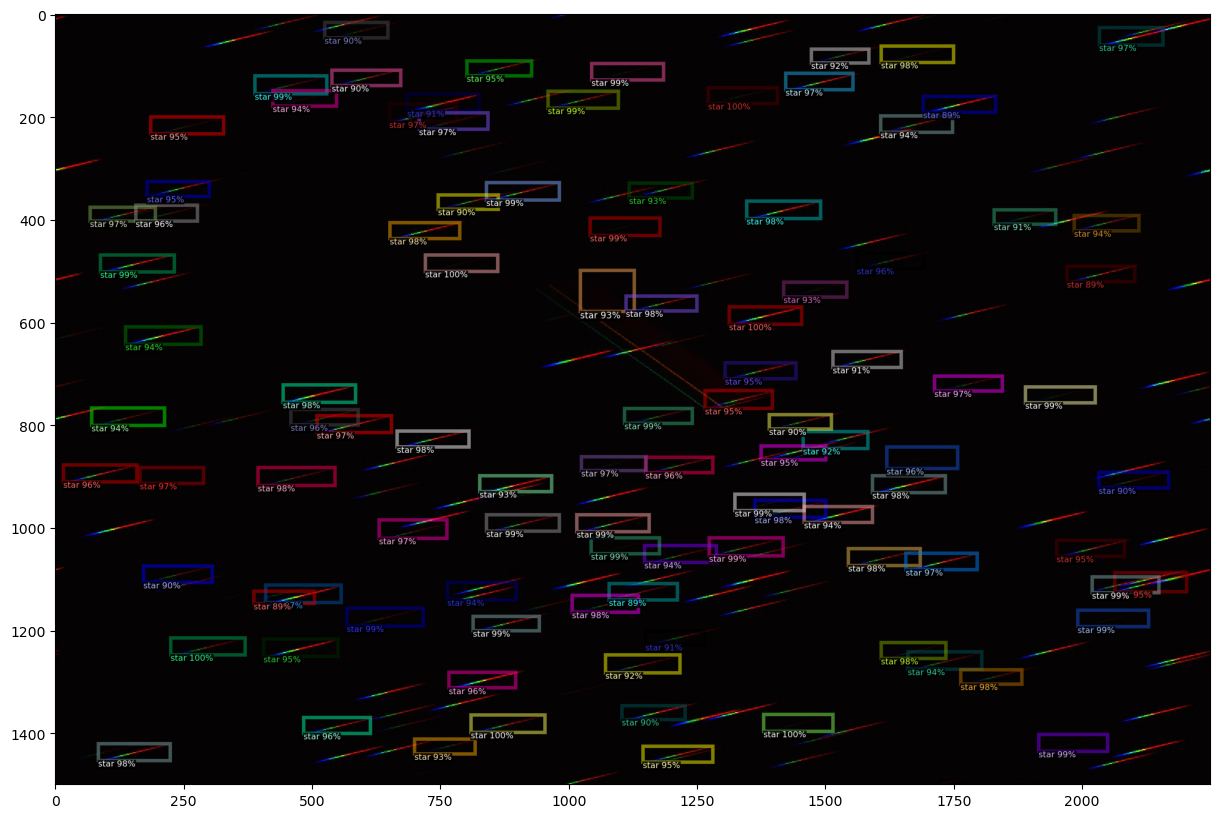

In [83]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0

# for d in random.sample(dataset_dicts, 1):    
im = plt.imread(d["file_name"])
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], metadata, scale=1.5)
print(outputs["instances"])
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=[15, 10])
plt.imshow(out.get_image()[:, :, ::-1])

# Evaluation

See how it works in our validation dataset (TODO) and the real image

Reference of the real image: `2021JIMO...49...71Z`

(1000, 1500, 3) uint8
[02/10 22:35:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/yl127/detectron2/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


Instances(num_instances=100, image_height=1000, image_width=1500, fields=[pred_boxes: Boxes(tensor([[ 113.9743,  819.7080,  199.1552,  850.7452],
        [ 989.3417,  433.1012, 1076.3624,  474.2120],
        [1318.8777,  241.1744, 1409.8625,  277.4504],
        [ 809.2263,  318.6765,  902.1250,  357.4991],
        [1236.9270,  104.1473, 1318.0854,  134.0273],
        [1083.1537,  536.7853, 1174.3639,  576.5342],
        [ 576.6076,  344.1483,  658.7401,  381.7953],
        [ 956.7731,  195.8729, 1049.6744,  236.0969],
        [ 830.2189,  386.8131,  929.0998,  426.8450],
        [ 140.9303,   19.9970,  229.3085,   60.7070],
        [ 117.4896,  362.8878,  199.0338,  397.3892],
        [ 813.5401,  153.1431,  899.4987,  190.1186],
        [ 993.8928,  518.3557, 1088.8656,  560.8557],
        [1262.9698,  269.7071, 1341.0939,  300.5270],
        [1233.1595,   54.2571, 1323.8127,   91.3230],
        [ 129.6798,  329.6442,  219.6441,  368.5978],
        [1290.5474,   88.5875, 1392.5023,  1

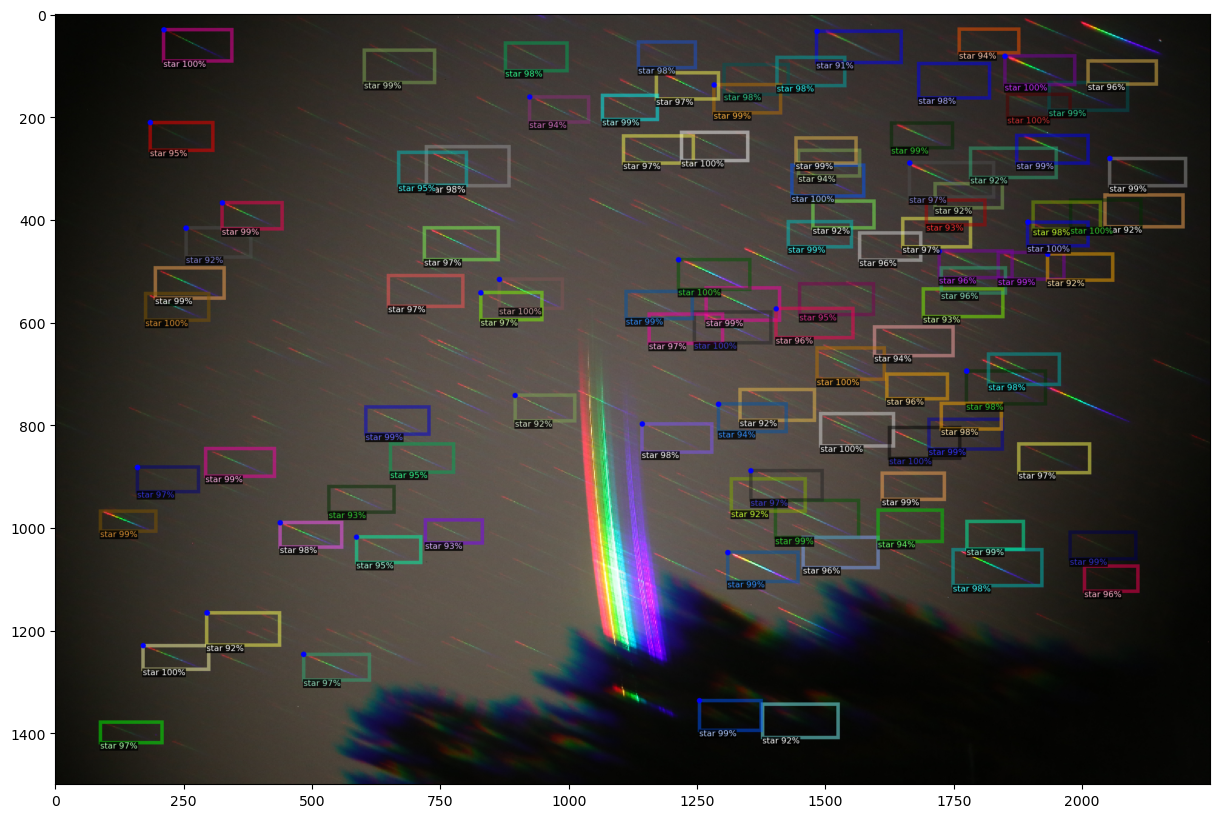

In [88]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9

del MetadataCatalog.get("fake_meteors").keypoint_names

im = plt.imread("testimg.jpg")
im = cv2.resize(im, dsize=(1500, 1000), interpolation=cv2.INTER_CUBIC)
print(im.shape, im.dtype)
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.5)
print(outputs["instances"])
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=[15, 10])
plt.imshow(out.get_image()[:, :, ::-1])

In [61]:
# import rawpy

# path = '../01/IMG_0241.CR2'
# with rawpy.imread(path) as raw:
# #     rgb = raw.postprocess(output_bps=16)
#     rgb_show = raw.postprocess(output_bps=8)

img = plt.imread('testimg.jpg')

img = cv2.resize(img, dsize=(1500, 1000), interpolation=cv2.INTER_CUBIC)

# plt.figure(figsize=[15, 10])
# plt.imshow(img, cmap=plt.cm.gray)
outputs = predictor(img)
v = Visualizer(img[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=[15, 10])
plt.imshow(out.get_image()[:, :, ::-1])

/home/yl127/detectron2/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


IndexError: list index out of range

In [10]:
metadata

namespace(name='fake_meteors',
          json_file='./dataset/labels.json',
          image_root='./dataset/',
          evaluator_type='coco',
          thing_classes=['meteor', 'star'],
          thing_dataset_id_to_contiguous_id={1: 0, 2: 1},
          keypoint_names=['meteor', 'star'],
          keypoint_flip_map=[])